In [1]:
from matplotlib import pyplot
from numpy import full, loadtxt, ones, where, log, arange
from numpy.random import default_rng
from scipy.stats import entropy
from seaborn import heatmap, histplot

def plot(f):
    x = arange(1, 100) / 100
    y = f(x)
    pyplot.plot(x, y) 
    pyplot.show()

def plot_p(p):
    pyplot.bar(arange(9), p) 
    pyplot.show()

# Wave function collapse

<div>
    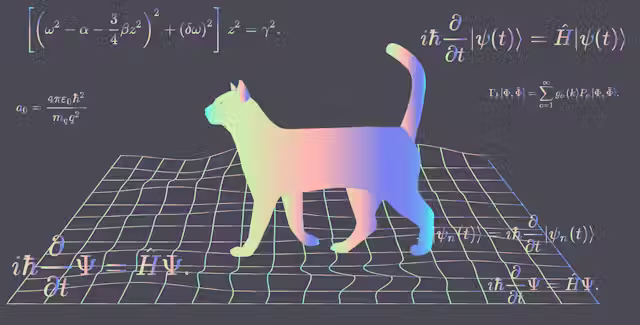
</div>

## Definitions

### Self information

$I(x) = - log \space P(x)$

The $log$ base is not relevant since we can do conversions knowing that $log_c(b) \cdot log_b(a) = log_c(a)$

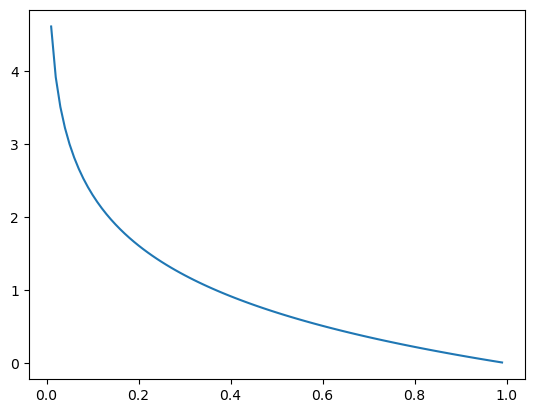

In [2]:
self_information = lambda x: -log(x)
plot(self_information)

<div>
    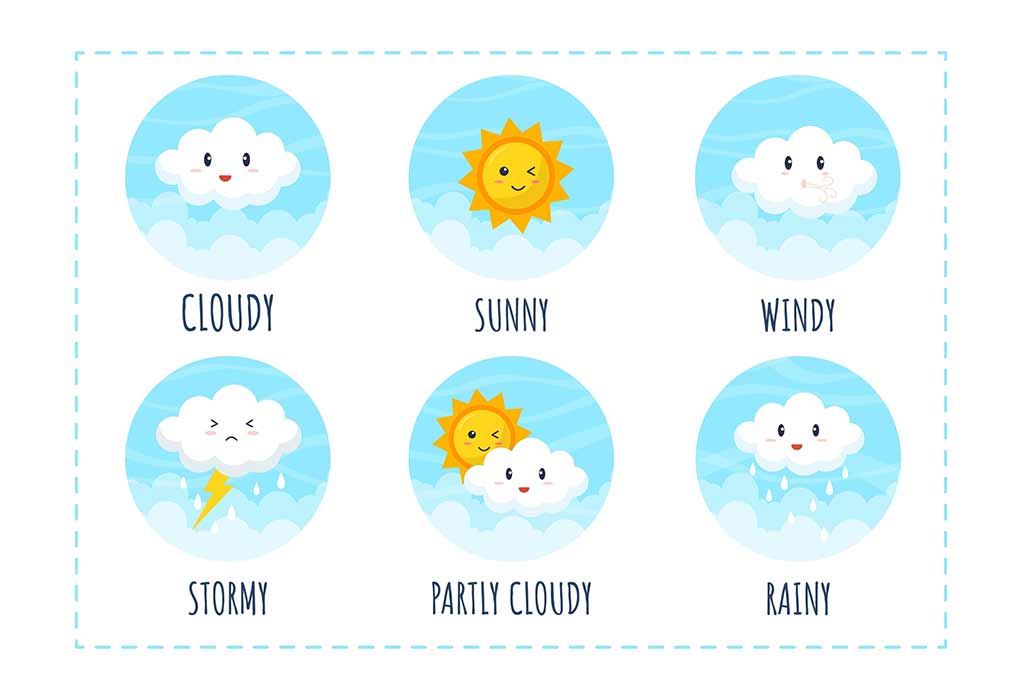
</div>

### Entropy

$H(X) = - \sum_i P(x_i) \cdot log \space P(x_i)$

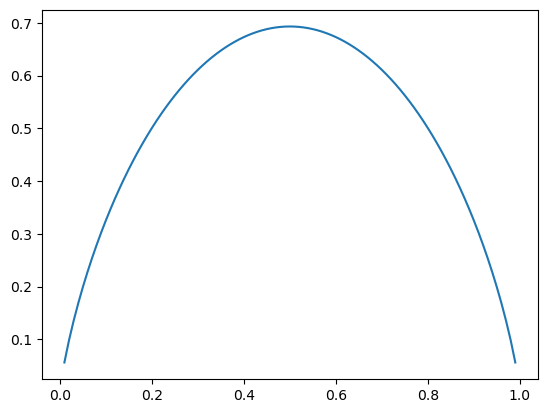

In [3]:
plot(lambda x: x*self_information(x)+(1-x)*self_information(1-x))

<div>
    <img src="./coin.jpg" width=600 />
</div>

## Solving sudoku

<div>
    <img src="sudoku.png" width=600>
</div>

### Wave implementation

<div>
    <img src="tensor.png" width=800>
</div>

In [4]:
class Wave:
    def __init__(self, shape, counts, rng):
        self.possible = ones((*shape, counts.size), dtype=int)
        self.counts = counts
        self.rng = rng

    @property
    def field_shape(self):
        return self.possible.shape[:-1]

    @property
    def states_number(self):
        return self.counts.size

    @property
    def histogram(self):
        return self.possible * self.counts

    @property
    def density(self):
        return self.histogram / self.histogram.sum(axis=-1, keepdims=True)

    @property
    def entropy(self):
        return entropy(self.density, base=self.states_number, axis=-1)

    @property
    def min_entropy(self):
        min_nonzero = self.entropy[self.entropy != 0].min()
        return where(self.entropy == min_nonzero)

    @property
    def collapsed(self):
        return self.density == 1

    @property
    def view(self):
        collapsed = where(self.collapsed)
        view = full(self.field_shape, -1)
        view[collapsed[:-1]] = collapsed[-1]
        return view

    def collapse(self, position, state):
        self.possible[*position] = 0
        self.possible[*position, state] = 1

    def observe(self, position):
        state = self.rng.choice(self.states_number, p=self.density[position])
        self.fix(position, state)

    def fix(self, position, state):
        self.collapse(position, state)
        collapsed = self.collapsed
        self.propagate_information(position, state)
        while (collapsed != self.collapsed).any():
            position = where(collapsed != self.collapsed)
            collapsed = self.collapsed
            self.propagate_information(position[:-1], position[-1])

    def propagate_information(self, position, state):
        raise NotImplementedError

### Sudoku wave implementation

In [5]:
class SudokuWave(Wave):
    def __init__(self, fixed_positions, fixed_states, rng):
        super().__init__((9, 9), ones(9), rng)
        self.fix(fixed_positions, fixed_states)

    def propagate_information(self, position, state):
        self.possible[position[0], :, state] = 0
        self.possible[:, position[1], state] = 0
        for x_offset in range(3):
            for y_offset in range(3):
                x = position[0] // 3 * 3 + x_offset
                y = position[1] // 3 * 3 + y_offset
                self.possible[x, y, state] = 0
        self.possible[*position, state] = 1

    @property
    def view(self):
        return super().view + 1

    @staticmethod
    def from_file(file, seed):
        sudoku = loadtxt(file, dtype=int, delimiter=",")
        clues_positions = sudoku.nonzero()
        clues_values = sudoku[clues_positions] - 1
        return SudokuWave(clues_positions, clues_values, seed)

    @property
    def valid(self):
        rule = [45, 45, 45, 45, 45, 45, 45, 45, 45]
        # Each Column should sum to 45
        a = (self.view.sum(axis=0) == rule).all()
        # Each row should sum to 45
        b = (self.view.sum(axis=1) == rule).all()
        # Each 3x3 section should sum to 45
        c = True
        for x in range(3):
            for y in range(3):
                if self.view[x*3:x*3+3, y*3:y*3+3].sum() != 45:
                    c = False
        return a and b and c

### Example

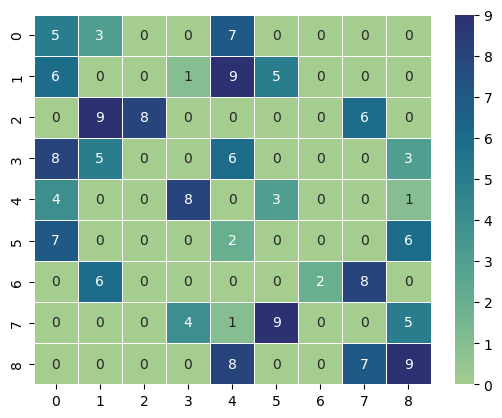

In [6]:
sudoku = loadtxt("simple.csv", delimiter=",")
heatmap(sudoku, annot=True, linewidth=.5, cmap="crest");

In [7]:
def run(seed):
    rng = default_rng(seed)
    wave = SudokuWave.from_file("simple.csv", rng)
    while wave.entropy.sum() != 0:
        position = wave.min_entropy
        i = rng.choice(position[0].size)
        wave.observe((position[0][i], position[1][i]))
    return wave


wave = run(0)
wave.valid


True

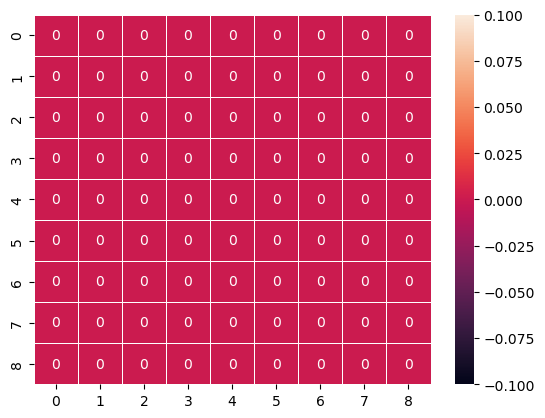

In [8]:
heatmap(wave.entropy, annot=True, linewidth=.5);

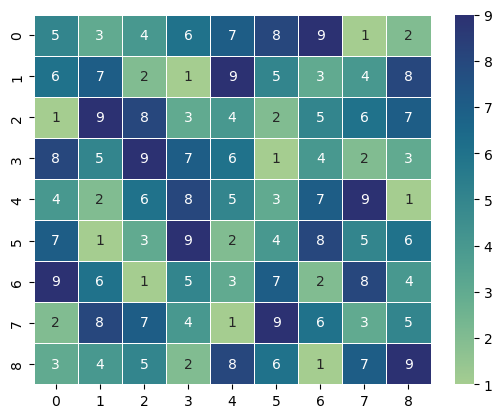

In [9]:
heatmap(wave.view, annot=True, linewidth=.5, cmap="crest");

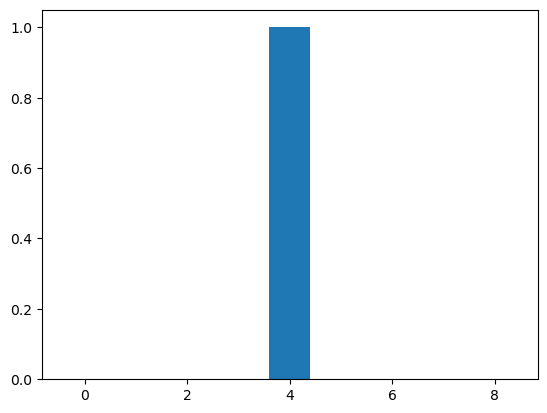

In [10]:
plot_p(wave.density[0, 0])